In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

years = range(2002,2018)
current_year_columns = ['FantasyPointsPerGame','PassingYards', 'PassingTouchdowns', 'PassingInterceptions', 'Played', 'RushingYards','RushingTouchdowns','Receptions','ReceivingYards','ReceivingTouchdowns','FumblesLost']
prev_year_columns = ['PrevPPG', 'PrevPassingYards','PrevPassingTouchdowns','PrevPassingInterceptions','PrevPlayed', 'PrevRushingYards','PrevRushingTouchdowns','PrevReceptions','PrevReceivingYards','PrevReceivingTouchdowns','PrevFumblesLost']
rolling_columns = ['RollingPPG', 'RollingPassingYards','RollingPassingTouchdowns','RollingPassingInterceptions','RollingPlayed', 'RollingRushingYards','RollingRushingTouchdowns','RollingReceptions','RollingReceivingYards','RollingReceivingTouchdowns','RollingFumblesLost']
feature_columns = rolling_columns + ['YearsInLeague']
target_column = 'FantasyPointsPerGame'



year_dfs = []
for year in years:
    year_df = pd.read_csv('./datasets/fantasy-football-leaders-{}.csv'.format(year))
    year_df['Year'] = year
    year_dfs.append(year_df)

all_players = pd.concat(year_dfs)
all_players = all_players.sort_values(['Name', 'Year'])
same_player_boolean_mask = all_players['Name'].shift() == all_players['Name']
all_players[prev_year_columns] = all_players[current_year_columns].shift()
all_players = all_players[same_player_boolean_mask]

all_players = all_players.set_index('Name')
all_players['RookieYear'] = all_players.groupby('Name')['Year'].min() - 1
all_players.reset_index(inplace=True)
all_players['YearsInLeague'] = all_players['Year'] - all_players['RookieYear']
all_players.head(15)

,Name,Team,Position,Played,PassingYards,PassingTouchdowns,PassingInterceptions,RushingYards,RushingTouchdowns,Receptions,...,PrevPassingInterceptions,PrevPlayed,PrevRushingYards,PrevRushingTouchdowns,PrevReceptions,PrevReceivingYards,PrevReceivingTouchdowns,PrevFumblesLost,RookieYear,YearsInLeague
0,A Becht,NYJ,WR,16,0,0,0,0,0,40,...,0.0,16.0,0.0,0.0,28.0,243.0,5.0,0.0,2002,1
1,A Bryant,DAL,WR,16,0,0,0,0,0,39,...,0.0,16.0,40.0,0.0,44.0,733.0,6.0,2.0,2002,1
2,A Bryant,CLE,WR,10,0,0,0,0,0,42,...,0.0,16.0,0.0,0.0,39.0,550.0,2.0,0.0,2002,2
3,A Bryant,DAL,WR,5,0,0,0,0,0,16,...,0.0,10.0,0.0,0.0,42.0,546.0,4.0,0.0,2002,2
4,A Bryant,CLE,WR,16,0,0,0,3,0,69,...,0.0,5.0,0.0,0.0,16.0,266.0,0.0,1.0,2002,3
5,A Bryant,SF,WR,14,0,0,0,0,0,40,...,0.0,16.0,3.0,0.0,69.0,1009.0,4.0,1.0,2002,4
6,A Cason,DAL,RB,10,37,0,0,220,2,17,...,0.0,10.0,107.0,0.0,19.0,288.0,2.0,0.0,2002,1
7,A Davis,CLE,WR,16,0,0,0,17,0,31,...,0.0,16.0,7.0,0.0,18.0,232.0,3.0,0.0,2002,1
8,A Davis,CLE,WR,7,0,0,0,-3,0,16,...,0.0,16.0,17.0,0.0,31.0,479.0,4.0,1.0,2002,2
9,A Davis,NE,WR,9,0,0,0,0,0,9,...,0.0,7.0,-3.0,0.0,16.0,416.0,2.0,0.0,2002,3


In [2]:
all_players = all_players.set_index('Name')
all_players[rolling_columns] = all_players.groupby('Name')[prev_year_columns].rolling(1).mean().reset_index(0, drop=True)
all_players.reset_index(inplace=True)
all_players[['Name'] + feature_columns]


,Name,RollingPPG,RollingPassingYards,RollingPassingTouchdowns,RollingPassingInterceptions,RollingPlayed,RollingRushingYards,RollingRushingTouchdowns,RollingReceptions,RollingReceivingYards,RollingReceivingTouchdowns,RollingFumblesLost,YearsInLeague
0,A Becht,3.5,0.0,0.0,0.0,16.0,0.0,0.0,28.0,243.0,5.0,0.0,1
1,A Bryant,6.8,0.0,0.0,0.0,16.0,40.0,0.0,44.0,733.0,6.0,2.0,1
2,A Bryant,4.2,0.0,0.0,0.0,16.0,0.0,0.0,39.0,550.0,2.0,0.0,2
3,A Bryant,7.9,0.0,0.0,0.0,10.0,0.0,0.0,42.0,546.0,4.0,0.0,2
4,A Bryant,4.9,0.0,0.0,0.0,5.0,0.0,0.0,16.0,266.0,0.0,1.0,3
5,A Bryant,7.7,0.0,0.0,0.0,16.0,3.0,0.0,69.0,1009.0,4.0,1.0,4
6,A Cason,5.2,0.0,0.0,0.0,10.0,107.0,0.0,19.0,288.0,2.0,0.0,1
7,A Davis,2.6,0.0,0.0,0.0,16.0,7.0,0.0,18.0,232.0,3.0,0.0,1
8,A Davis,4.5,0.0,0.0,0.0,16.0,17.0,0.0,31.0,479.0,4.0,1.0,2
9,A Davis,7.6,0.0,0.0,0.0,7.0,-3.0,0.0,16.0,416.0,2.0,0.0,3


In [3]:
## KNN Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

X = all_players['RollingPPG'].values.reshape(-1,1)
y = all_players['FantasyPointsPerGame'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
knnreg = KNeighborsRegressor(n_neighbors = 6).fit(X_train, y_train)
print('R-squared test score: {:.3f}'
     .format(knnreg.score(X_test, y_test)))


R-squared test score: 0.465


In [4]:
## Linear Regression
from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(X_train, y_train)

print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {}'
     .format(linreg.intercept_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

linear model coeff (w): [[ 0.7311004]]
linear model intercept (b): [ 1.98092692]
R-squared score (training): 0.536
R-squared score (test): 0.546


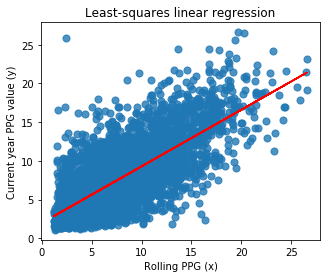

In [5]:
plt.figure(figsize=(5,4))
plt.scatter(X, y, marker= 'o', s=50, alpha=0.8)
plt.plot(X, linreg.coef_ * X + linreg.intercept_, 'r-')
plt.title('Least-squares linear regression')
plt.xlabel('Rolling PPG (x)')
plt.ylabel('Current year PPG value (y)')
plt.show()

In [6]:
## Ridge regression
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.linear_model import Ridge

X = all_players[feature_columns].values
y = all_players['FantasyPointsPerGame'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linridge = Ridge(alpha=1).fit(X_train_scaled, y_train)

print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))

ridge regression linear model intercept: [ 5.10024559]
ridge regression linear model coeff:
[[ 10.04399203   6.80451229   2.12558793   1.1632452   -2.52603232
    4.8863859    0.39172192   0.81459747   3.64002535  -0.82665093
    0.89906385  -0.65374226]]
R-squared score (training): 0.573
R-squared score (test): 0.572
Number of non-zero features: 12


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from sklearn.linear_model import Lasso

X = all_players[feature_columns].values
y = all_players['FantasyPointsPerGame'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linlasso = Lasso(alpha=0.0001, max_iter=60000).fit(X_train_scaled, y_train)

print('lasso regression linear model intercept: {}'
     .format(linlasso.intercept_))
print('lasso regression linear model coeff:\n{}'
     .format(linlasso.coef_))
print('R-squared score (training): {:.3f}'
     .format(linlasso.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linlasso.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linlasso.coef_ != 0)))

lasso regression linear model intercept: [ 5.1049833]
lasso regression linear model coeff:
[ 10.09148893   8.21482013   0.75665495   0.54914337  -2.57917463
   5.23877922  -0.           0.46384518   4.22529205  -1.01454981
   0.78664369  -0.69502557]
R-squared score (training): 0.574
R-squared score (test): 0.572
Number of non-zero features: 11


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

position_to_analyze = 'TE'
# position_players = all_players[all_players['Position'] != position_to_analyze] 
position_players = all_players

X = position_players[feature_columns].values
y = position_players['FantasyPointsPerGame'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

linreg = LinearRegression().fit(X_train, y_train)

print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {}'
     .format(linreg.intercept_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

print('\nNow we transform the original input data to add\n\
polynomial features up to degree 2 (quadratic)\n')
poly = PolynomialFeatures(degree=2)
X_F1_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_F1_poly, y,
                                                   random_state = 0)
linreg = LinearRegression().fit(X_train, y_train)

print('(poly deg 2) linear model coeff (w):\n{}'
     .format(linreg.coef_))
print('(poly deg 2) linear model intercept (b): {}'
     .format(linreg.intercept_))
print('(poly deg 2) R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('(poly deg 2) R-squared score (test): {:.3f}\n'
     .format(linreg.score(X_test, y_test)))

print('\nAddition of many polynomial features often leads to\n\
overfitting, so we often use polynomial features in combination\n\
with regression that has a regularization penalty, like ridge\n\
regression.\n')

X_train, X_test, y_train, y_test = train_test_split(X_F1_poly, y,
                                                   random_state = 0)
linreg = Ridge().fit(X_train, y_train)

print('(poly deg 2 + ridge) linear model coeff (w):\n{}'
     .format(linreg.coef_))
print('(poly deg 2 + ridge) linear model intercept (b): {}'
     .format(linreg.intercept_))
print('(poly deg 2 + ridge) R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('(poly deg 2 + ridge) R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

linear model coeff (w): [[  3.94752441e-01   1.50013546e-03   1.52989478e-02   1.91670464e-02
   -1.86111522e-01   2.48854434e-03   7.52203002e-06   3.39519432e-03
    2.16509518e-03  -4.42392517e-02   7.14051453e-02  -5.00689036e-02]]
linear model intercept (b): [ 5.18530328]
R-squared score (training): 0.574
R-squared score (test): 0.572

Now we transform the original input data to add
polynomial features up to degree 2 (quadratic)

(poly deg 2) linear model coeff (w):
[[ -4.38106352e-12   3.39848801e-01   4.15128932e-03  -7.56162548e-01
    6.85508481e-01   4.24332228e-01  -9.94112033e-03   1.15624051e-01
   -3.26195256e-03  -7.76374293e-03  -1.26307509e+00   1.05986215e+00
   -3.35819719e-01   1.21710216e-02  -4.74227209e-04   7.24491090e-02
   -4.02228620e-02  -1.86311665e-02   1.03390178e-03  -7.26821510e-02
   -2.56941862e-03   6.12663531e-04   7.29957254e-02  -8.69796345e-02
    2.77748876e-02   1.00040847e-06  -3.10363585e-05   1.86665440e-04
   -3.22913636e-04   9.17661960e-0

In [13]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# fix random seed for reproducibility
seed = 7

# define base model
def baseline_model():    
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [10]:
# fix random seed for reproducibility
numpy.random.seed(seed)

# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=10, batch_size=5, verbose=0)

kfold  = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -11.01 (1.73) MSE


In [11]:


# evaluate model with standardized dataset
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))


Standardized: -8.88 (1.27) MSE


In [12]:
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [13]:
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Larger: -8.95 (1.31) MSE


In [9]:
# wider model
def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [14]:
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=wider_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Wider: -8.95 (1.24) MSE
